In [20]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm
from spectral_cube import SpectralCube
import regions
from regions import Regions
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

In [23]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [24]:
import cutout_manager as cm

In [25]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [3]:
hpg = True

if hpg:
    basepath_jwst = '/orange/adamginsburg/jwst/cloudc/images/'
    basepath_glimpse = '/orange/adamginsburg/cmz/glimpse_data/'
    fn_cont_B3 = '/orange/adamginsburg/jwst/cloudc/alma/ACES/uid___A001_X15a0_X1a8.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0'
    fn_cont_B6 = ''
else:
    basepath_jwst = '/home/savannahgramze/research/Research/JWST/cloudc/images/'
    basepath_glimpse = '/home/savannahgramze/research/Research/glimpse/'

fn_405 = f'{basepath_jwst}/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'#F405_reproj_merged-fortricolor.fits'
fn_410 = f'{basepath_jwst}/jw02221-o002_t001_nircam_clear-f410m-merged_i2d.fits'#F410_reproj_merged-fortricolor.fits'
fn_466 = f'{basepath_jwst}/jw02221-o002_t001_nircam_clear-f466n-merged_i2d.fits'#F466_reproj_merged-fortricolor.fits'
fn_187 = f'{basepath_jwst}/F187_reproj_merged-fortricolor.fits'
fn_182 = f'{basepath_jwst}/F182_reproj_merged-fortricolor.fits'
fn_212 = f'{basepath_jwst}/F212_reproj_merged-fortricolor.fits'

In [21]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

# Three Color Images

In [4]:
def get405():
    return fits.open(fn_405)['SCI']

def get410():
    return fits.open(fn_410)['SCI']

def get466():
    return fits.open(fn_466)['SCI']

def get_rgb():
    cutout_R = get466()
    cutout_B = get405()
    cutout_G = cutout_R.data + cutout_B.data

    rgb = np.array(
        [
            cutout_R.data,
            cutout_G,
            cutout_B.data
        ]
    ).swapaxes(0,2).swapaxes(0,1)

    rgb[rgb <= 0] = np.nan

    rgb_scaled = np.array([
        simple_norm(rgb[:,:,0], stretch='asinh', vmin=-1, vmax=90)(rgb[:,:,0]),
        simple_norm(rgb[:,:,1], stretch='asinh', vmin=-2, vmax=210)(rgb[:,:,1]),
        simple_norm(rgb[:,:,2], stretch='asinh', vmin=-1, vmax=120)(rgb[:,:,2]),
    ]).swapaxes(0,2)

    return rgb_scaled.swapaxes(0,1), WCS(cutout_R.header)

In [5]:
img, ww = get_rgb()

In [6]:
img = (img*256)
img[img<0] = 0
img[img>255] = 255

In [7]:
import cv2

In [8]:
mask_0 = np.logical_and(img[:,:,0]==0, img[:,:,1]==0, img[:,:,2]==0)
mask_nan = np.logical_and(np.isnan(img[:,:,0]), np.isnan(img[:,:,1]), np.isnan(img[:,:,2]))
mask = np.logical_or(mask_0, mask_nan)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
dilate = cv2.dilate(mask.astype('uint8'), kernel, iterations=1)
mask = np.array(dilate, dtype=bool)

img = np.append(img, np.array([~mask]).swapaxes(0,2).swapaxes(0,1)*255, axis=2)
img = img.astype('uint8')

/scratch/local/51867057/ipykernel_3744473/2125026140.py:9: RuntimeWarning: invalid value encountered in cast
  img = img.astype('uint8')


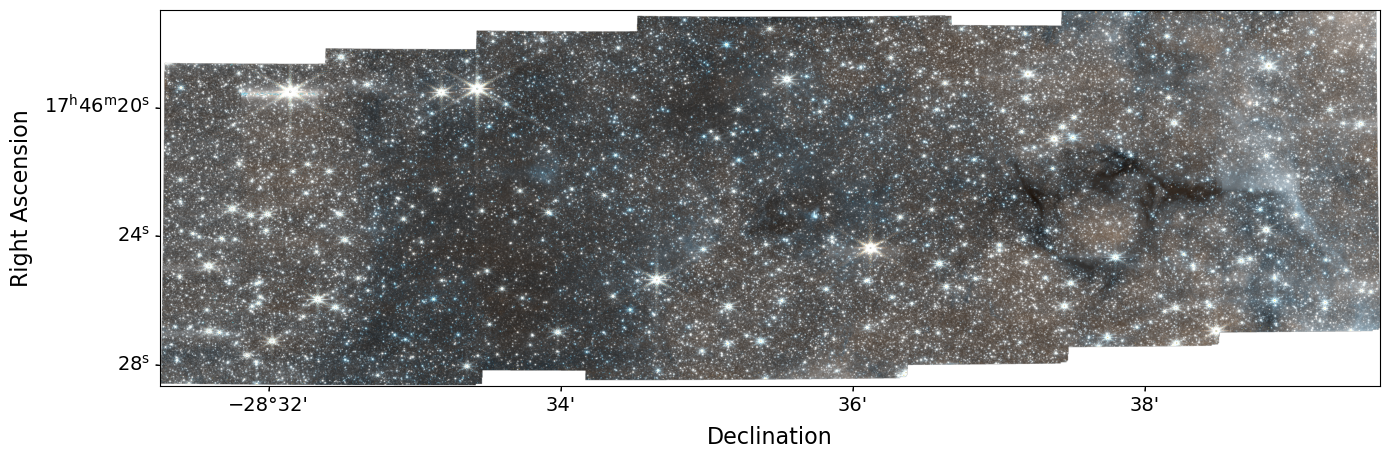

In [16]:
fig = plt.figure(figsize=(14,7))
ax = plt.subplot(projection=ww)
ax.imshow(img, origin='lower')
dec = ax.coords[1]
ra = ax.coords[0]
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')
dec.set_ticklabel(size=14)
ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
ra.set_ticklabel(size=14)

ax.set_ylabel('Right Ascension', fontsize=16)
ax.set_xlabel('Declination', fontsize=16)
plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/jwst_405_466_rgb.png', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/jwst_405_466_rgb.pdf', dpi=300, bbox_inches='tight')

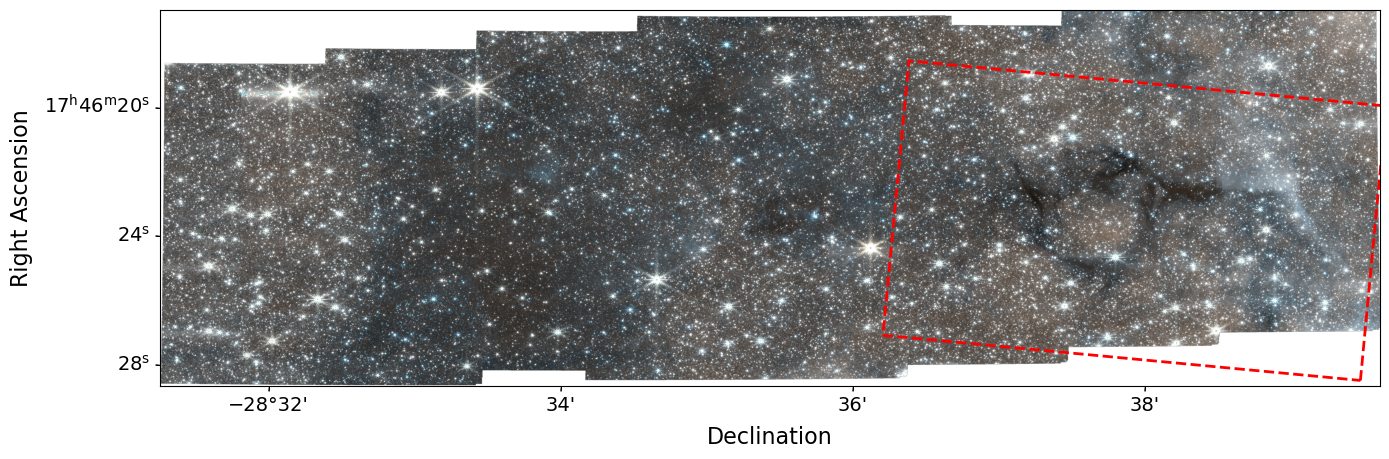

In [22]:
fig = plt.figure(figsize=(14,7))
ax = plt.subplot(projection=ww)
ax.imshow(img, origin='lower')
dec = ax.coords[1]
ra = ax.coords[0]
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')
dec.set_ticklabel(size=14)
ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
ra.set_ticklabel(size=14)

reg.to_pixel(ww).plot(ax=ax, edgecolor='red', facecolor='none', lw=2, linestyle='--')

ax.set_ylabel('Right Ascension', fontsize=16)
ax.set_xlabel('Declination', fontsize=16)
plt.tight_layout()

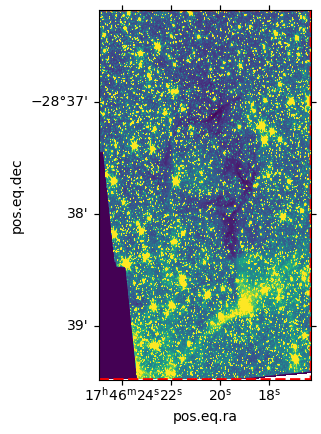

In [29]:
cut405 = cm.get_cutout_405(pos, w, l)
ax = plt.subplot(projection=cut405.wcs)
ax.imshow(cut405.data, origin='lower', vmin=0, vmax=50)
reg.to_pixel(cut405.wcs).plot(ax=ax, edgecolor='red', facecolor='none', lw=2, linestyle='--')